In [1]:
# pip install pywavelets

In [18]:
import numpy as np 
import pandas as pd    
import matplotlib.pyplot as plt
import mne
import seaborn as sns
import os

# Manally controlling the process. 

In [11]:
import os
import mne

# Load and Parse Data


def load_and_parse_data(P_folder):
    all_edf_file_paths = [os.path.join(P_folder, f) for f in os.listdir(P_folder) if f.endswith('.edf')]
    summary_file_path = [os.path.join(P_folder, f) for f in os.listdir(P_folder) if f.endswith('.txt')][0]
    
    with open(summary_file_path, 'r') as file:
        summary_content = file.readlines()

    seizure_times = parse_seizure_times(summary_content)
    return all_edf_file_paths, seizure_times


def parse_seizure_times(summary_content):
    seizure_times = {}
    current_file = None
    summary_iterator = iter(summary_content)  # Convert list to iterator

    for line in summary_iterator:
        if 'File Name' in line:
            current_file = line.split(':')[-1].strip()
            seizure_times[current_file] = []
        elif 'Seizure' in line and 'Start Time' in line:
            start_time = int(line.split(':')[-1].strip().split(' ')[0])
            end_time_line = next(summary_iterator)
            if 'End Time' in end_time_line:
                end_time = int(end_time_line.split(':')[-1].strip().split(' ')[0])
                seizure_times[current_file].append((start_time, end_time))
    
    return seizure_times

# Annotate EEG Data
def annotate_eeg_data(raw, seizure_times, preictal_duration=30*60, postictal_duration=10*60, buffer_duration=30*60):
    file_name = os.path.basename(raw.filenames[0])

    if file_name in seizure_times:
        last_end = 0
        for start, end in seizure_times[file_name]:
            if start - preictal_duration - buffer_duration > 0 and last_end < start - preictal_duration - buffer_duration:
                raw.annotations.append(onset=start - preictal_duration - buffer_duration, duration=buffer_duration, description='buffer_before_preictal')
            
            preictal_start = max(last_end, start - preictal_duration)
            preictal_duration_actual = start - preictal_start
            if preictal_duration_actual > 0:  # Ensure positive duration
                raw.annotations.append(onset=preictal_start, duration=preictal_duration_actual, description='preictal')
            
            duration = end - start
            raw.annotations.append(onset=start, duration=duration, description='ictal')
            
            postictal_start = end
            postictal_duration_actual = min(postictal_duration, raw.times[-1] - postictal_start)
            if postictal_duration_actual > 0:  # Ensure positive duration
                raw.annotations.append(onset=postictal_start, duration=postictal_duration_actual, description='postictal')

            last_end = postictal_start + postictal_duration_actual + buffer_duration
        
        if last_end < raw.times[-1]:
            interictal_duration = raw.times[-1] - last_end
            if interictal_duration > 0:  # Ensure positive duration
                raw.annotations.append(onset=last_end, duration=interictal_duration, description='interictal')
    else:
        raw.annotations.append(onset=0, duration=raw.times[-1], description='interictal')

    return raw

In [12]:
# Preprocess the EEG Data
def preprocess_eeg_data(raw):
    # raw = ChannelSelection(raw)
    raw.filter(l_freq=0.5, h_freq=100)
    raw_notch = raw.copy().notch_filter(freqs=[60], notch_widths=6)
    return raw_notch



# Function to crop and save annotations
def crop_and_save_annotations(raw, subject_folder, file_name):
    # Initialize a counter dictionary to keep track of file numbers for each description
    description_count = {}

    for ann in raw.annotations:
        description = ann['description']
        onset = ann['onset']
        duration = ann['duration']
        
        # Increment the counter for the description
        if description in description_count:
            description_count[description] += 1
        else:
            description_count[description] = 1

        # Crop the raw data based on the annotation's onset and duration
        cropped_raw = raw.copy().crop(tmin=onset, tmax=onset + duration)
        cropped_raw.set_meas_date(None)
        
        # Create output folder for this annotation type if it doesn't exist
        annotation_folder = os.path.join(subject_folder, description)
        if not os.path.exists(annotation_folder):
            os.makedirs(annotation_folder)
        
        # Construct a unique filename using the counter
        output_file = os.path.join(annotation_folder, f"{file_name}_{description}_{description_count[description]}_raw.fif")
        
        # Save the cropped data
        cropped_raw.save(output_file, overwrite=True)
        print(f"Saved {description} segment to {output_file}")

# Process and save the EEG data
def process_and_save(edf_file, raw, seizure_times):
    raw = preprocess_eeg_data(raw)
    raw.set_meas_date(None)
    file_name = os.path.basename(edf_file)
    subject_name = file_name.split('_')[0]
    subject_folder = os.path.join(P_folder, subject_name)

    # Check if the file contains seizures
    if file_name in seizure_times and len(seizure_times[file_name]) > 0:
        crop_and_save_annotations(raw, subject_folder, file_name)
    else:
        # Move to normal folder
        normal_folder = os.path.join(subject_folder, 'interictal')
        if not os.path.exists(normal_folder):
            os.makedirs(normal_folder)
        output_file = os.path.join(normal_folder, file_name.replace('.edf', '_normal_raw.fif'))
        raw.save(output_file, overwrite=True)
        print(f"Saved interictal segment to {output_file}")

##### not considered yet: 12-27,28,29

In [13]:
# Example usage
P_folder = r'E:\New folder\chb24'
all_edf_file_paths, seizure_times = load_and_parse_data(P_folder)
seizure_times

{'chb24_01.edf': [(480, 505), (2451, 2476)],
 'chb24_03.edf': [(231, 260), (2883, 2908)],
 'chb24_04.edf': [(1088, 1120), (1411, 1438), (1745, 1764)],
 'chb24_06.edf': [(1229, 1253)],
 'chb24_07.edf': [(38, 60)],
 'chb24_09.edf': [(1745, 1764)],
 'chb24_11.edf': [(3527, 3597)],
 'chb24_13.edf': [(3288, 3304)],
 'chb24_14.edf': [(1939, 1966)],
 'chb24_15.edf': [(3552, 3569)],
 'chb24_17.edf': [(3515, 3581)],
 'chb24_21.edf': [(2804, 2872)]}

In [15]:
run_process = all_edf_file_paths[3]
raw = mne.io.read_raw_edf(run_process, preload=True)
raw = annotate_eeg_data(raw, seizure_times)
raw.plot()

Extracting EDF parameters from E:\New folder\chb24\chb24_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\2824424209.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(run_process, preload=True)


Channels marked as bad:
none


In [16]:
def ChannelSelection(signal):

    # List of channels to retain
    desired_channels = [
        'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
        'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
        'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
        'FP2-F8', 'F8-T8', 'T8-P8-0','T8-P8', 'P8-O2',
        'FZ-CZ', 'CZ-PZ', 'T7-FT9',
        'FT9-FT10', 'FT10-T8'
    ]

    # Check existing channels in the signal
    available_channels = signal.info['ch_names']

    # Filter desired channels based on availability in the signal
    selected_channels = [ch for ch in desired_channels if ch in available_channels]

    # Pick only the selected channels
    signal.pick_channels(selected_channels)

    # Rename channel if needed
    if 'T8-P8-0' in signal.info['ch_names']:
        channel_mapping = {'T8-P8-0': 'T8-P8'}
        mne.rename_channels(signal.info, channel_mapping)

    return signal
raw = ChannelSelection(raw)
raw.plot()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Channels marked as bad:
none


In [17]:
process_and_save(run_process, raw, seizure_times)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Writing E:\New folder\chb24\chb24\preictal\chb24_04.edf_preictal_1_raw.fif
Closing E:\New folder\chb24\chb24\preictal\chb24_04.edf_preictal_1_raw.fif
[done]
Saved preictal segment to E:\New folder\chb24\chb24\preictal\chb24_04.edf_preictal_1_raw.fif
Writing E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_1_raw.fif
Closing E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_1_raw.fif
[done]
Saved ictal segment to E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_1_raw.fif
Writing E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_2_raw.fif
Closing E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_2_raw.fif
[done]
Saved ictal segment to E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_2_raw.fif
Writing E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_3_raw.fif
Closing E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_3_raw.fif
[done]
Saved ictal segment to E:\New folder\chb24\chb24\ictal\chb24_04.edf_ictal_3_raw.fif
Writing E:\New folder\chb24\chb24\postictal\chb24_04.edf_postic

# File in Loop

In [19]:
import os
import shutil
import mne

# Load and Parse Data
def load_and_parse_data(P_folder):
    all_edf_file_paths = [os.path.join(P_folder, f) for f in os.listdir(P_folder) if f.endswith('.edf')]
    summary_file_path = [os.path.join(P_folder, f) for f in os.listdir(P_folder) if f.endswith('.txt')][0]
    
    with open(summary_file_path, 'r') as file:
        summary_content = file.readlines()

    seizure_times = parse_seizure_times(summary_content)
    return all_edf_file_paths, seizure_times

def parse_seizure_times(summary_content):
    seizure_times = {}
    current_file = None
    summary_iterator = iter(summary_content)  # Convert list to iterator

    for line in summary_iterator:
        if 'File Name' in line:
            current_file = line.split(':')[-1].strip()
            seizure_times[current_file] = []
        elif 'Seizure' in line and 'Start Time' in line:
            start_time = int(line.split(':')[-1].strip().split(' ')[0])
            end_time_line = next(summary_iterator)
            if 'End Time' in end_time_line:
                end_time = int(end_time_line.split(':')[-1].strip().split(' ')[0])
                seizure_times[current_file].append((start_time, end_time))
    
    return seizure_times



# Annotate EEG Data
def annotate_eeg_data(raw, seizure_times, preictal_duration=30*60, postictal_duration=10*60, buffer_duration=30*60):
    file_name = os.path.basename(raw.filenames[0])

    if file_name in seizure_times:
        last_end = 0
        for start, end in seizure_times[file_name]:
            if start - preictal_duration - buffer_duration > 0 and last_end < start - preictal_duration - buffer_duration:
                raw.annotations.append(onset=start - preictal_duration - buffer_duration, duration=buffer_duration, description='buffer_before_preictal')
            
            preictal_start = max(last_end, start - preictal_duration)
            preictal_duration_actual = start - preictal_start
            if preictal_duration_actual > 0:  # Ensure positive duration
                raw.annotations.append(onset=preictal_start, duration=preictal_duration_actual, description='preictal')
            
            duration = end - start
            raw.annotations.append(onset=start, duration=duration, description='ictal')
            
            postictal_start = end
            postictal_duration_actual = min(postictal_duration, raw.times[-1] - postictal_start)
            if postictal_duration_actual > 0:  # Ensure positive duration
                raw.annotations.append(onset=postictal_start, duration=postictal_duration_actual, description='postictal')

            last_end = postictal_start + postictal_duration_actual + buffer_duration
        
        if last_end < raw.times[-1]:
            interictal_duration = raw.times[-1] - last_end
            if interictal_duration > 0:  # Ensure positive duration
                raw.annotations.append(onset=last_end, duration=interictal_duration, description='interictal')
    else:
        raw.annotations.append(onset=0, duration=raw.times[-1], description='interictal')

    return raw


# Preprocess the EEG Data
def preprocess_eeg_data(raw):
    raw = ChannelSelection(raw)
    raw.filter(l_freq=0.5, h_freq=100)
    raw_notch = raw.copy().notch_filter(freqs=[60], notch_widths=6)
    return raw_notch

def ChannelSelection(signal):

    # List of channels to retain
    desired_channels = [
        'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
        'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
        'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
        'FP2-F8', 'F8-T8', 'T8-P8-0','T8-P8', 'P8-O2',
        'FZ-CZ', 'CZ-PZ', 'T7-FT9',
        'FT9-FT10', 'FT10-T8'
    ]

    # Check existing channels in the signal
    available_channels = signal.info['ch_names']

    # Filter desired channels based on availability in the signal
    selected_channels = [ch for ch in desired_channels if ch in available_channels]

    # Pick only the selected channels
    signal.pick_channels(selected_channels)

    # Rename channel if needed
    if 'T8-P8-0' in signal.info['ch_names']:
        channel_mapping = {'T8-P8-0': 'T8-P8'}
        mne.rename_channels(signal.info, channel_mapping)

    return signal

        

            

# Function to crop and save annotations
def crop_and_save_annotations(raw, subject_folder, file_name):
    # Initialize a counter dictionary to keep track of file numbers for each description
    description_count = {}

    for ann in raw.annotations:
        description = ann['description']
        onset = ann['onset']
        duration = ann['duration']
        
        # Increment the counter for the description
        if description in description_count:
            description_count[description] += 1
        else:
            description_count[description] = 1

        # Crop the raw data based on the annotation's onset and duration
        cropped_raw = raw.copy().crop(tmin=onset, tmax=onset + duration)
        cropped_raw.set_meas_date(None)
        
        # Create output folder for this annotation type if it doesn't exist
        annotation_folder = os.path.join(subject_folder, description)
        if not os.path.exists(annotation_folder):
            os.makedirs(annotation_folder)
        
        # Construct a unique filename using the counter
        output_file = os.path.join(annotation_folder, f"{file_name}_{description}_{description_count[description]}_raw.fif")
        
        # Save the cropped data
        cropped_raw.save(output_file, overwrite=True)
        print(f"Saved {description} segment to {output_file}")



# Process and Annotate Data, then Save Based on Annotation Type
def process_and_save(P_folder):
    all_edf_file_paths, seizure_times = load_and_parse_data(P_folder)
    
    
    print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>{seizure_times}")
    for edf_file in all_edf_file_paths:
        print(f"Processing {edf_file}...")
        raw = mne.io.read_raw_edf(edf_file, preload=True)

        
        
        raw = annotate_eeg_data(raw, seizure_times)
        raw = preprocess_eeg_data(raw)
        raw.plot()
        raw.set_meas_date(None)   # Setting meas_date to None
        

        # raw.plot()
        file_name = os.path.basename(edf_file)
        subject_name = file_name.split('_')[0]
        subject_folder = os.path.join(P_folder, subject_name)

        # Check if the file contains seizures
        if file_name in seizure_times and len(seizure_times[file_name]) > 0:
            # Process and save ictal, preictal, postictal data
            crop_and_save_annotations(raw, subject_folder, file_name)
            # raw.plot()
        else:
            # Move to normal folder
            normal_folder = os.path.join(subject_folder, 'interictal')
            if not os.path.exists(normal_folder):
                os.makedirs(normal_folder)
            raw.save(os.path.join(normal_folder, file_name.replace('.edf', '_normal_raw.fif')), overwrite=True)


process_and_save(r'E:\New folder\chb11')


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>{'chb11_01.edf': [], 'chb11_02.edf': [], 'chb11_03.edf': [], 'chb11_04.edf': [], 'chb11_05.edf': [], 'chb11_06.edf': [], 'chb11_07.edf': [], 'chb11_08.edf': [], 'chb11_09.edf': [], 'chb11_10.edf': [], 'chb11_11.edf': [], 'chb11_12.edf': [], 'chb11_13.edf': [], 'chb11_14.edf': [], 'chb11_15.edf': [], 'chb11_16.edf': [], 'chb11_17.edf': [], 'chb11_18.edf': [], 'chb11_19.edf': [], 'chb11_24.edf': [], 'chb11_25.edf': [], 'chb11_26.edf': [], 'chb11_27.edf': [], 'chb11_53.edf': [], 'chb11_54.edf': [], 'chb11_55.edf': [], 'chb11_56.edf': [], 'chb11_58.edf': [], 'chb11_60.edf': [], 'chb11_61.edf': [], 'chb11_62.edf': [], 'chb11_63.edf': [], 'chb11_82.edf': [(298, 320)], 'chb11_92.edf': [(2695, 2727)], 'chb11_99.edf': [(1454, 2206)]}
Processing E:\New folder\chb11\chb11_01.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structu

C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Writing E:\New folder\chb11\chb11\interictal\chb11_01_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_01_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_02.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Writing E:\New folder\chb11\chb11\interictal\chb11_02_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_02_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_03.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Writing E:\New folder\chb11\chb11\interictal\chb11_03_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_03_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_04.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Writing E:\New folder\chb11\chb11\interictal\chb11_04_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_04_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_05.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Writing E:\New folder\chb11\chb11\interictal\chb11_05_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_05_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_06.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Writing E:\New folder\chb11\chb11\interictal\chb11_06_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_06_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_07.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_07_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_07_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_08.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_08_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_08_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_09.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_09_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_09_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_10.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Writing E:\New folder\chb11\chb11\interictal\chb11_10_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_10_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_11.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_11_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_11_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_12.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_12_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_12_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_13.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Writing E:\New folder\chb11\chb11\interictal\chb11_13_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_13_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_14.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Writing E:\New folder\chb11\chb11\interictal\chb11_14_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_14_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_15.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Writing E:\New folder\chb11\chb11\interictal\chb11_15_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_15_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_16.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_16_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_16_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_17.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Writing E:\New folder\chb11\chb11\interictal\chb11_17_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_17_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_18.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_18_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_18_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_19.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Writing E:\New folder\chb11\chb11\interictal\chb11_19_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_19_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_24.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_24_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_24_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_25.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_25_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_25_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_26.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_26_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_26_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_27.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_27_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_27_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_53.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_53.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Writing E:\New folder\chb11\chb11\interictal\chb11_53_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_53_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_54.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_54_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_54_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_55.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_55.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_55_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_55_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_56.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_56_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_56_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_58.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_58_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_58_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_60.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\interictal\chb11_60_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_60_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_61.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Writing E:\New folder\chb11\chb11\interictal\chb11_61_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_61_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_62.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Writing E:\New folder\chb11\chb11\interictal\chb11_62_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_62_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_63.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Writing E:\New folder\chb11\chb11\interictal\chb11_63_normal_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_63_normal_raw.fif
[done]
Processing E:\New folder\chb11\chb11_82.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_82.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Writing E:\New folder\chb11\chb11\preictal\chb11_82.edf_preictal_1_raw.fif
Closing E:\New folder\chb11\chb11\preictal\chb11_82.edf_preictal_1_raw.fif
[done]
Saved preictal segment to E:\New folder\chb11\chb11\preictal\chb11_82.edf_preictal_1_raw.fif
Writing E:\New folder\chb11\chb11\ictal\chb11_82.edf_ictal_1_raw.fif
Closing E:\New folder\chb11\chb11\ictal\chb11_82.edf_ictal_1_raw.fif
[done]
Saved ictal segment to E:\New folder\chb11\chb11\ictal\chb11_82.edf_ictal_1_raw.fif
Writing E:\New folder\chb11\chb11\postictal\chb11_82.edf_postictal_1_raw.fif
Closing E:\New folder\chb11\chb11\postictal\chb11_82.edf_postictal_1_raw.fif
[done]
Saved postictal segment to E:\New folder\chb11\chb11\postictal\chb11_82.edf_postictal_1_raw.fif
Writing E:\New folder\chb11\chb11\interictal\chb11_82.edf_interictal_1_raw.fif
Closing E:\New folder\chb11\chb11\interictal\chb11_82.edf_interictal_1_raw.fif
[done]
Saved interictal segment to E:\New folder\chb11\chb11\interictal\chb11_82.edf_interictal_1_raw.fif


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing E:\New folder\chb11\chb11\preictal\chb11_92.edf_preictal_1_raw.fif
Closing E:\New folder\chb11\chb11\preictal\chb11_92.edf_preictal_1_raw.fif
[done]
Saved preictal segment to E:\New folder\chb11\chb11\preictal\chb11_92.edf_preictal_1_raw.fif
Writing E:\New folder\chb11\chb11\ictal\chb11_92.edf_ictal_1_raw.fif
Closing E:\New folder\chb11\chb11\ictal\chb11_92.edf_ictal_1_raw.fif
[done]
Saved ictal segment to E:\New folder\chb11\chb11\ictal\chb11_92.edf_ictal_1_raw.fif
Writing E:\New folder\chb11\chb11\postictal\chb11_92.edf_postictal_1_raw.fif
Closing E:\New folder\chb11\chb11\postictal\chb11_92.edf_postictal_1_raw.fif
[done]
Saved postictal segment to E:\New folder\chb11\chb11\postictal\chb11_92.edf_postictal_1_raw.fif
Processing E:\New folder\chb11\chb11_99.edf...
Extracting EDF parameters from E:\New folder\chb11\chb11_99.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 731903  =      0.000 ...  2858.996 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_14248\298778749.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 56.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Upper passband edge: 63.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Writing E:\New folder\chb11\chb11\preictal\chb11_99.edf_preictal_1_raw.fif
Closing E:\New folder\chb11\chb11\preictal\chb11_99.edf_preictal_1_raw.fif
[done]
Saved preictal segment to E:\New folder\chb11\chb11\preictal\chb11_99.edf_preictal_1_raw.fif
Writing E:\New folder\chb11\chb11\ictal\chb11_99.edf_ictal_1_raw.fif
Closing E:\New folder\chb11\chb11\ictal\chb11_99.edf_ictal_1_raw.fif
[done]
Saved ictal segment to E:\New folder\chb11\chb11\ictal\chb11_99.edf_ictal_1_raw.fif
Writing E:\New folder\chb11\chb11\postictal\chb11_99.edf_postictal_1_raw.fif
Closing E:\New folder\chb11\chb11\postictal\chb11_99.edf_postictal_1_raw.fif
[done]
Saved postictal segment to E:\New folder\chb11\chb11\postictal\chb11_99.edf_postictal_1_raw.fif


# not decided


In [29]:

print("###############################################", edf_file, "###########################################################")
raw = mne.io.read_raw_edf(all_edf_file_paths[0], preload=True)
raw = annotate_eeg_data(raw, seizure_times)

channels = [
        'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
        'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
        'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
        'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2',
        'FZ-CZ', 'CZ-PZ', 'T7-FT9',
        'FT9-FT10', 'FT10-T8',
    ]

raw.pick_channels(channels)
channel_mapping = {'T8-P8-0': 'T8-P8'}
mne.rename_channels(raw.info, channel_mapping)
raw = preprocess_eeg_data(raw)
raw.plot()
    

NameError: name 'edf_file' is not defined

In [45]:
process_and_save(P_folder,raw)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Channel names are not the same!!
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 56 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


OSError: The filename (D:\archive\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12\interictal\chb12) for file type raw must end with .fif or .fif.gz

In [7]:
annotated_raws.plot()

Channels marked as bad:
none


In [14]:
import os
import mne
import pywt
import numpy as np


# Load and Parse Data
def load_and_parse_data(P_folder):
    all_edf_file_paths = [os.path.join(P_folder, f) for f in os.listdir(P_folder) if f.endswith('.edf')]
    summary_file_path = [os.path.join(P_folder, f) for f in os.listdir(P_folder) if f.endswith('.txt')][0]
    
    with open(summary_file_path, 'r') as file:
        summary_content = file.readlines()

    seizure_times = parse_seizure_times(summary_content)
    return all_edf_file_paths, seizure_times

def parse_seizure_times(summary_content):
    seizure_times = {}
    current_file = None
    for line in summary_content:
        if 'File Name' in line:
            current_file = line.split(':')[-1].strip()
            seizure_times[current_file] = []
        elif 'Seizure Start Time' in line:
            start_time = int(line.split(':')[-1].strip().split(' ')[0])
        elif 'Seizure End Time' in line:
            end_time = int(line.split(':')[-1].strip().split(' ')[0])
            seizure_times[current_file].append((start_time, end_time))
    return seizure_times

# Annotate EEG Data
def annotate_eeg_data(raw, seizure_times, preictal_duration=30*60, postictal_duration=10*60, buffer_duration=30*60):
    file_name = os.path.basename(raw.filenames[0])

    if file_name in seizure_times:
        for start, end in seizure_times[file_name]:
            # Exclude buffer before preictal period
            if start - preictal_duration - buffer_duration > 0:
                raw.annotations.append(onset=start - preictal_duration - buffer_duration, duration=buffer_duration, description='buffer_before_preictal')
            
            # Annotate preictal period
            preictal_start = max(0, start - preictal_duration)
            preictal_duration_actual = start - preictal_start
            raw.annotations.append(onset=preictal_start, duration=preictal_duration_actual, description='preictal')
            
            # Annotate ictal period
            duration = end - start
            raw.annotations.append(onset=start, duration=duration, description='ictal')
            
            # Annotate postictal period
            postictal_start = end
            postictal_duration_actual = min(postictal_duration, raw.times[-1] - postictal_start)
            raw.annotations.append(onset=postictal_start, duration=postictal_duration_actual, description='postictal')
            
            # Exclude buffer after postictal period
            if postictal_start + postictal_duration_actual + buffer_duration < raw.times[-1]:
                raw.annotations.append(onset=postictal_start + postictal_duration_actual, duration=buffer_duration, description='buffer_after_postictal')
            
        # Annotate remaining time as interictal
        last_end = 0
        for start, end in seizure_times[file_name]:
            if last_end < preictal_start:
                raw.annotations.append(onset=last_end, duration=preictal_start - last_end, description='interictal')
            last_end = end + postictal_duration_actual + buffer_duration
        if last_end < raw.times[-1]:
            raw.annotations.append(onset=last_end, duration=raw.times[-1] - last_end, description='interictal')
    else:
        raw.annotations.append(onset=0, duration=raw.times[-1], description='interictal')

    return raw

# Preprocess the EEG Data
def preprocess_eeg_data(raw):
    raw = ChannelSelection(raw)
    raw.filter(l_freq=0.5, h_freq=127.9)
    raw_notch = raw.copy().notch_filter(freqs=[60, 120], notch_widths=6)
    return raw_notch

def ChannelSelection(signal):
    try:
        channels = [
            'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
            'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
            'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
            'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2',
            'FZ-CZ', 'CZ-PZ', 'T7-FT9',
            'FT9-FT10', 'FT10-T8',
        ]

        signal.pick_channels(channels)
        channel_mapping = {'T8-P8-0': 'T8-P8'}
        mne.rename_channels(signal.info, channel_mapping)
        return signal
    except:
        print("Channel names are not the same!!")
        return signal

def DWT(data):
    eeg_data = data.get_data()
    dwt_coeffs = []
    for channel_data in eeg_data:
        wavelet = 'db4'
        coeffs = pywt.wavedec(channel_data, wavelet, level=5)
        dwt_coeffs.append(coeffs)
    return dwt_coeffs



# Combine Methods to Process, Annotate, and Combine Raw Data
def process_and_annotate(P_folder):
    all_edf_file_paths, seizure_times = load_and_parse_data(P_folder)
    raw_list = []

    for edf_file in all_edf_file_paths[]:
        print("###############################################", edf_file, "###########################################################")
        raw = mne.io.read_raw_edf(edf_file, preload=True)
        raw = annotate_eeg_data(raw, seizure_times)
        raw = preprocess_eeg_data(raw)
        raw_list.append(raw)

    # Combine all the raw objects into one
    combined_raw = mne.concatenate_raws(raw_list)

    # Create epochs and labels from the combined raw data
    # X, Y, events, epochs = create_epochs_and_labels(combined_raw)

    # Save the epochs based on their event type
    # save_epochs_by_event_type(X, Y, P_folder)
    
    return combined_raw

# Example usage
P_folder = 'D:\\CHB_MIT'
raw_new = process_and_annotate(P_folder)


############################################### D:\CHB_MIT\chb01_01.edf ###########################################################
Extracting EDF parameters from D:\CHB_MIT\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\ACER\AppData\Local\Temp\ipykernel_13224\871240929.py:117: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 127.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 127.95 Hz)
- Filter length: 8449 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


############################################### D:\CHB_MIT\chb01_02.edf ###########################################################
Extracting EDF parameters from D:\CHB_MIT\chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\ACER\AppData\Local\Temp\ipykernel_13224\871240929.py:117: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 127.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 127.95 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


In [12]:
raw_new.plot()

Using qt as 2D backend.


Channels marked as bad:
none


In [4]:
new_raw = mne.concatenate_raws(annotated_raws)

NameError: name 'annotated_raws' is not defined

In [12]:
annotated_raws[3].plot()

Channels marked as bad:
none


In [23]:
import mne

# Path to the saved .fif file
fif_file_path = 'D:\\CHB_MIT\\chb01\\ictal\\chb01_03.edf_ictal_raw.fif'

# Load the .fif file
raw = mne.io.read_raw_fif(fif_file_path, preload=True)

# Print basic information about the file
print(raw.info)

# Plot the first 10 channels over a duration of 20 seconds
raw.plot(n_channels=10, duration=20)

# Print annotations if any
print(raw.annotations)

Opening raw data file D:\CHB_MIT\chb01\ictal\chb01_03.edf_ictal_raw.fif...
Isotrak not found
    Range : 766976 ... 777216 =   2996.000 ...  3036.000 secs
Ready.
Reading 0 ... 10240  =      0.000 ...    40.000 secs...
<Info | 10 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 21 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 127.9 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>
<Annotations | 3 segments: ictal (1), postictal (1), preictal (1)>
Channels marked as bad:
none


In [4]:
x,y, event, epoch = create_fixed_length_epochs_with_ids(raw_new)

Used Annotations descriptions: ['ictal', 'interictal', 'postictal', 'preictal']
Not setting metadata
14598 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14598 events and 2560 original time points ...
22 bad epochs dropped


C:\Users\ACER\AppData\Local\Temp\ipykernel_4920\4140143360.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), Y, epochs.events, epochs


In [8]:
pd.DataFrame(y).value_counts()

0
0    14516
4       39
1        7
2        7
3        7
Name: count, dtype: int64

In [9]:
raw_new.plot(events=event)

Channels marked as bad:
none


In [40]:
epochs.plot(events=epochs.events)

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [9]:
raw.filter(0.5, 100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Measurement date,"November 06, 2076 13:43:04 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [10]:
# Applying a notch filter at 60 Hz
raw.notch_filter(freqs=60, method = 'fir', fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Measurement date,"November 06, 2076 13:43:04 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


C:\Users\ACER\mne-python\1.7.1_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


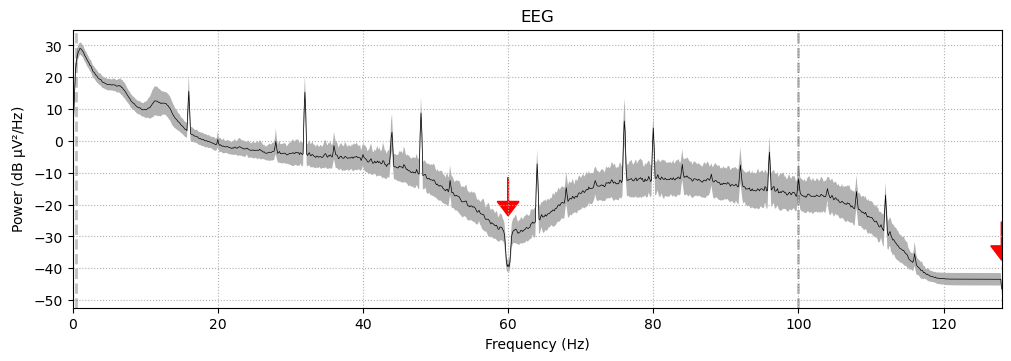

In [11]:
def add_arrows(axes):
    """Add some arrows at 60 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (60, 128):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )

fig = raw.compute_psd(fmax=128).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
add_arrows(fig.axes[:2])

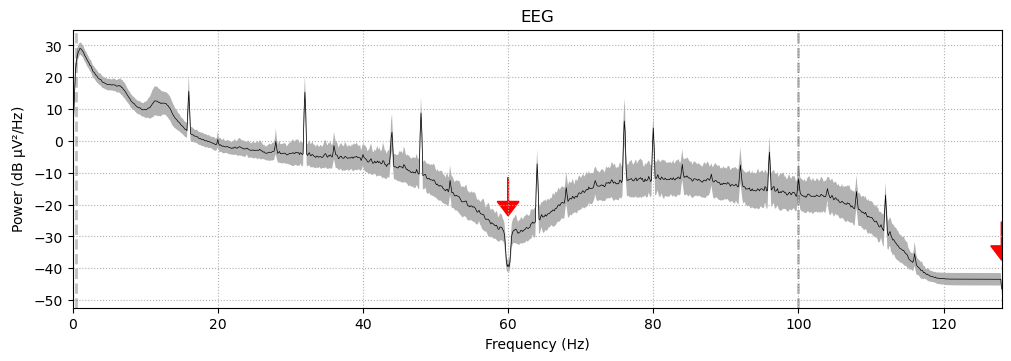

In [12]:
fig

In [13]:
raw_notch_fit = raw.copy().notch_filter(
    freqs=256, picks='all', method="spectrum_fit", filter_length="10s"
)
for title, data in zip(["Un", "spectrum_fit "], [raw, raw_notch_fit]):
    fig = data.compute_psd(fmax=128).plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{title}filtered", size="xx-large", weight="bold")
    add_arrows(fig.axes[:2])

Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
    128.00 : 15099 windows
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Effective window size : 8.000 (s)


C:\Users\ACER\mne-python\1.7.1_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


C:\Users\ACER\mne-python\1.7.1_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


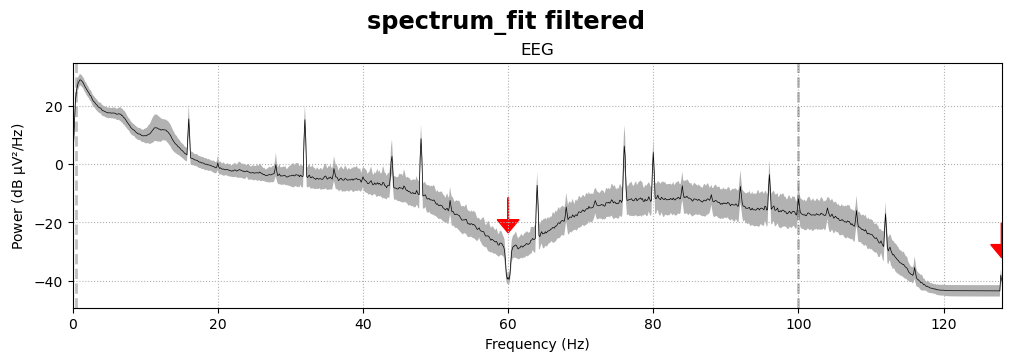

In [14]:
fig

In [15]:
raw.resample(256, npad="auto")

Sampling frequency of the instance is already 256.0, returning unmodified.


Measurement date,"November 06, 2076 13:43:04 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [16]:
raw.set_eeg_reference('average', projection=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Measurement date,"November 06, 2076 13:43:04 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [17]:
# Apply the projection
raw.apply_proj()

Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,"November 06, 2076 13:43:04 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [18]:
raw.info['projs']

[<Projection | Average EEG reference, active : True, n_channels : 21>]

In [19]:
raw.plot()

In [20]:
%%capture
!pip install pyedflib
!pip install PyWavelets

In [21]:
# Ensure all necessary libraries are installed
!pip install pyedflib numpy pandas matplotlib pillow scikit-learn PyWavelets

In [22]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import linear_model
import pywt
import matplotlib.patches as patches
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier as KNN



In [23]:
# Load the edf file
f = pyedflib.EdfReader("D:\CHB_MIT\chb01_03.edf")
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

# and load the data into a DataFrame
df_signals = pd.DataFrame(sigbufs)
df_signals = df_signals.transpose()
df_signals.columns = signal_labels

In [24]:
signal_labels

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8']

# Funcion buliding


In [25]:
import pywt

def ChannelSelection(signal):
    try: 
        channels = [
            'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
            'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
            'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
            'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2',
            'FZ-CZ', 'CZ-PZ', 'T7-FT9',
            'FT9-FT10', 'FT10-T8',
            ]


        # Select only the unique, standardized channels
        signal.pick_channels(channels)
        # Rename 'T8-P8-0' to 'T8-P8'
        channel_mapping = {'T8-P8-0': 'T8-P8'}
        mne.rename_channels(signal.info, channel_mapping)

        return signal
    except:
        print("Channel name are not same!!")



def DWT(data):

    # Get the EEG data as a NumPy array
    eeg_data = data.get_data()
    
    # List to store DWT coefficients for each channel
    dwt_coeffs = []
    
    # Perform DWT on each channel separately
    for channel_data in eeg_data:
        # Perform 5-level DWT using the Daubechies-4 wavelet
        wavelet = 'db4'
        coeffs = pywt.wavedec(channel_data, wavelet, level=5)
        dwt_coeffs.append(coeffs)
    
    return dwt_coeffs
    





def preprocessing(path):
    raw = mne.io.read_raw_edf(path, preload=True)
    # List of channels with some inconsistencies
    raw = ChannelSelection(raw)
    
    # Apply a bandpass filter (0.5 to 70 Hz)
    raw.filter(l_freq=0.5, h_freq=127.9)
    raw_notch = raw.copy().notch_filter(freqs=[60, 120], notch_widths=6)  # notch_widths defines the width of the notch
    raw.plot()
    data = DWT(raw_notch)

    return data
    


In [26]:
raw = preprocessing('D:\CHB_MIT\chb01_03.edf')

Extracting EDF parameters from D:\CHB_MIT\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 127.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 127.95 Hz)
- Filter length: 8449 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


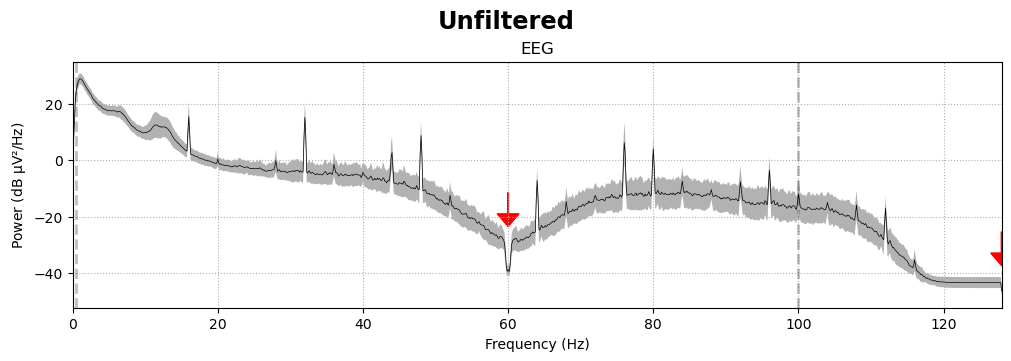

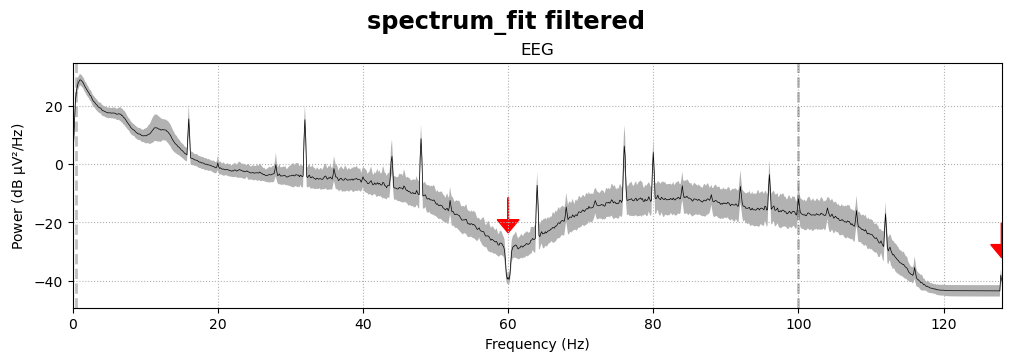

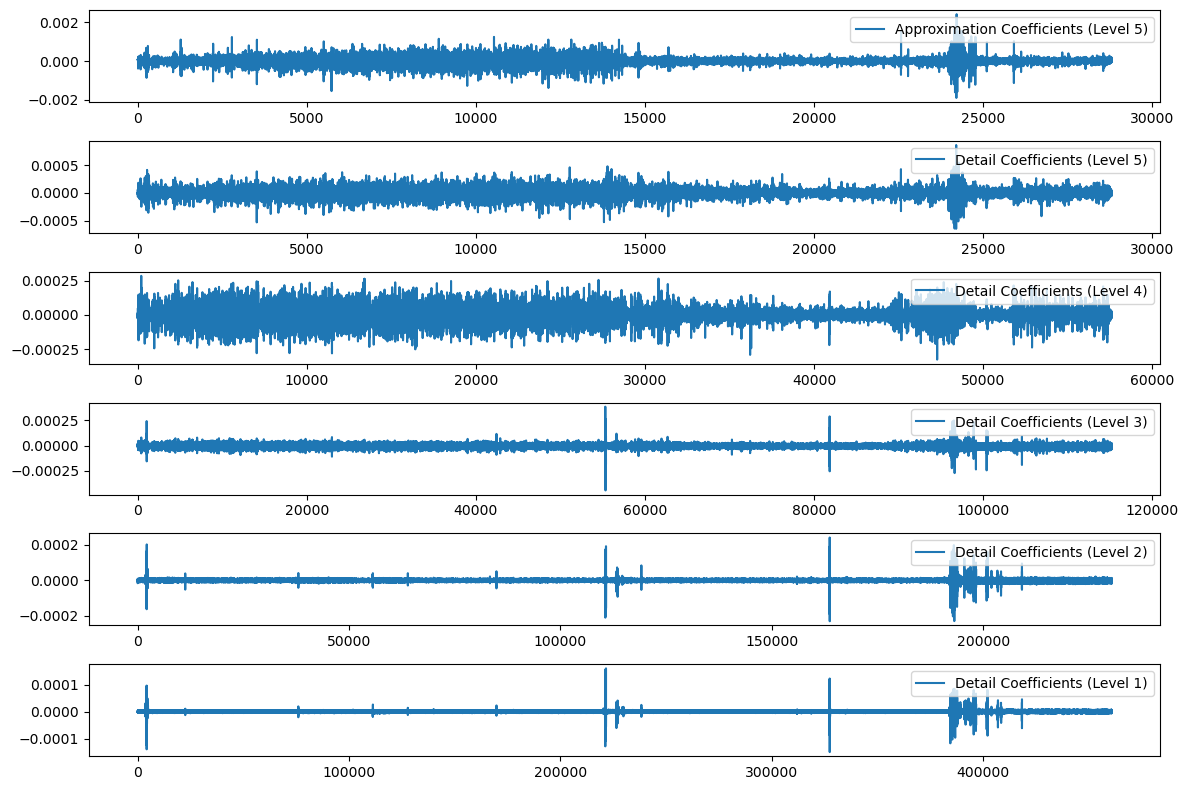

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [27]:
# Plot DWT coefficients for the first channel as an example
plt.figure(figsize=(12, 8))

# Plot Approximation Coefficients (Level 5)
plt.subplot(6, 1, 1)
plt.plot(raw[0][0], label=f'Approximation Coefficients (Level 5)')
plt.legend(loc='upper right')

# Plot Detail Coefficients from Level 4 to Level 1
for i in range(1, 6):
    plt.subplot(6, 1, i+1)
    plt.plot(raw[0][i], label=f'Detail Coefficients (Level {6-i})')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()